# What's New in `dynesty` v3.0

This notebook demonstrates the key changes and improvements in dynesty v3.0. For a complete list of changes, see the [CHANGELOG](https://github.com/joshspeagle/dynesty/blob/master/CHANGELOG.md).

## Setup

In [1]:
import numpy as np
import dynesty
from dynesty import plotting as dyplot
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

# Seed for reproducibility
rstate = np.random.default_rng(42)

## Test Problem: 2-D Gaussian

We'll use a simple 2-D Gaussian likelihood for demonstration purposes.

In [2]:
ndim = 2

def loglike(x):
    """2-D Gaussian log-likelihood."""
    return -0.5 * np.sum(x**2)

def prior_transform(u):
    """Uniform prior from -10 to 10."""
    return 10 * (2 * u - 1)

## 1. Proposal Statistics

The `results` object now contains a `proposal_stats` attribute that provides detailed statistics about the sampling process, including the number of accepted and rejected proposals for each sampler used.

In [3]:
sampler = dynesty.NestedSampler(loglike, prior_transform, ndim, rstate=rstate, sample='rwalk')
sampler.run_nested()
results = sampler.results

2509it [00:02, 904.51it/s, +500 | bound: 2 | nc: 1 | ncall: 34111 | eff(%):  8.952 | loglstar:   -inf < -0.000 <    inf | logz: -4.172 +/-  0.080 | dlogz:  0.001 >  0.509]


In [4]:
# Access proposal statistics
# proposal_stats is an array (one entry per sample) of dictionaries
print("Proposal Statistics Summary:")
print("=" * 50)
print(f"Total samples: {len(results.proposal_stats)}")
print(f"Samples with proposal stats: {sum(1 for ps in results.proposal_stats if ps is not None)}")
print()

# Show some example proposal statistics
print("Example proposal statistics from individual samples:")
for i, ps in enumerate(results.proposal_stats[::-1]):
    if ps is not None:
        print(f"Sample {i}: {ps}")
        break


Proposal Statistics Summary:
Total samples: 3009
Samples with proposal stats: 2509

Example proposal statistics from individual samples:
Sample 500: {'n_accept': 10, 'n_reject': 12}


## 2. Saving Likelihood Evaluation History

A new feature allows you to save all likelihood evaluations to an HDF5 file using `save_evaluation_history=True` and `history_filename`. This is useful for debugging and analyzing the sampler's behavior. This will work even if you are sampling multiple threads and 

In [5]:
sampler2 = dynesty.NestedSampler(loglike, prior_transform, ndim, 
                                 save_evaluation_history=True, 
                                 sample='rslice',
                                 history_filename="demo_history.h5",
                                 rstate=rstate)
sampler2.run_nested()
results2 = sampler2.results

2524it [00:04, 615.16it/s, +500 | bound: 8 | nc: 1 | ncall: 37333 | eff(%):  8.210 | loglstar:   -inf < -0.001 <    inf | logz: -4.203 +/-  0.080 | dlogz:  0.001 >  0.509]


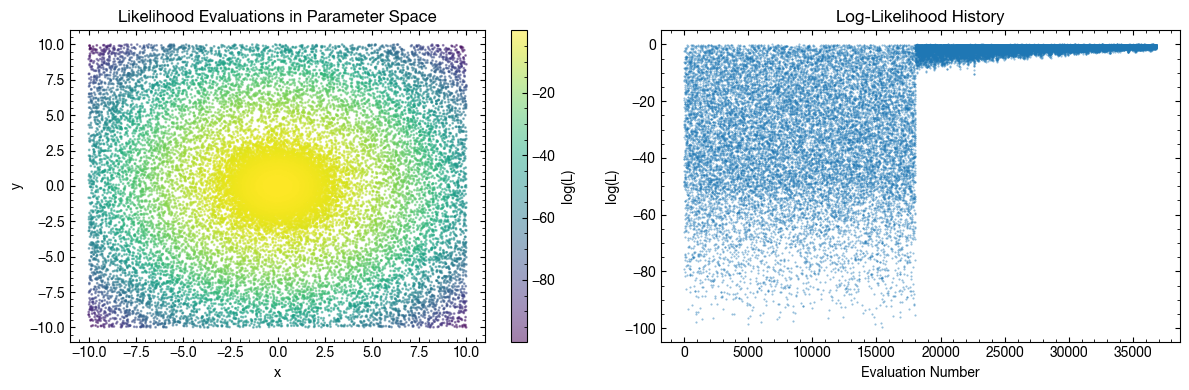

Total evaluations saved: 36833


In [6]:
# Read and visualize the evaluation history
with h5py.File('demo_history.h5', 'r') as f:
    history_v = f['evaluation_v'][:]
    history_logl = f['evaluation_logl'][:]

# Plot the evaluation history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot evaluations in parameter space, colored by log-likelihood
scatter = ax1.scatter(history_v[:, 0], history_v[:, 1], 
                      c=history_logl, cmap='viridis', s=1, alpha=0.5)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Likelihood Evaluations in Parameter Space')
plt.colorbar(scatter, ax=ax1, label='log(L)')

# Plot log-likelihood vs evaluation number
ax2.plot(history_logl, '.', markersize=1, alpha=0.5)
ax2.set_xlabel('Evaluation Number')
ax2.set_ylabel('log(L)')
ax2.set_title('Log-Likelihood History')

plt.tight_layout()
plt.show()

print(f"Total evaluations saved: {len(history_logl)}")
# Cleanup
import os
if os.path.exists('demo_history.h5'):
    os.remove('demo_history.h5')

## 3. New InternalSampler Interface

In v3.0, you can now provide sampler instances directly instead of just using string names. This allows for more fine-grained control over sampling parameters.

### Method 1: Specifying sampler by string (classic approach)

In [7]:
rstate = np.random.default_rng(100)
sampler_str = dynesty.NestedSampler(loglike, prior_transform, ndim, 
                                    sample='rwalk', rstate=rstate)
sampler_str.run_nested()
results_str = sampler_str.results
print(f"Evidence (string method): {results_str.logz[-1]:.3f} ± {results_str.logzerr[-1]:.3f}")

2560it [00:02, 911.71it/s, +500 | bound: 2 | nc: 1 | ncall: 34965 | eff(%):  8.879 | loglstar:   -inf < -0.000 <    inf | logz: -4.276 +/-  0.081 | dlogz:  0.001 >  0.509]

Evidence (string method): -4.276 ± 0.158


### Method 2: Specifying sampler by instance (new in v3.0)

In [8]:
from dynesty.internal_samplers import RWalkSampler

rstate = np.random.default_rng(100)

# Create a custom sampler instance with specific parameters
custom_sampler = RWalkSampler(walks=25)  # More walks than default

sampler_inst = dynesty.NestedSampler(loglike, prior_transform, ndim, 
                                     sample=custom_sampler, rstate=rstate)
sampler_inst.run_nested()
results_inst = sampler_inst.results
print(f"Evidence (instance method): {results_inst.logz[-1]:.3f} ± {results_inst.logzerr[-1]:.3f}")

2557it [00:02, 884.03it/s, +500 | bound: 2 | nc: 1 | ncall: 37077 | eff(%):  8.358 | loglstar:   -inf < -0.000 <    inf | logz: -4.267 +/-  0.081 | dlogz:  0.001 >  0.509]

Evidence (instance method): -4.267 ± 0.158


Comparing string method vs instance method:
String method evidence: -4.276 ± 0.158
Instance method evidence: -4.267 ± 0.158


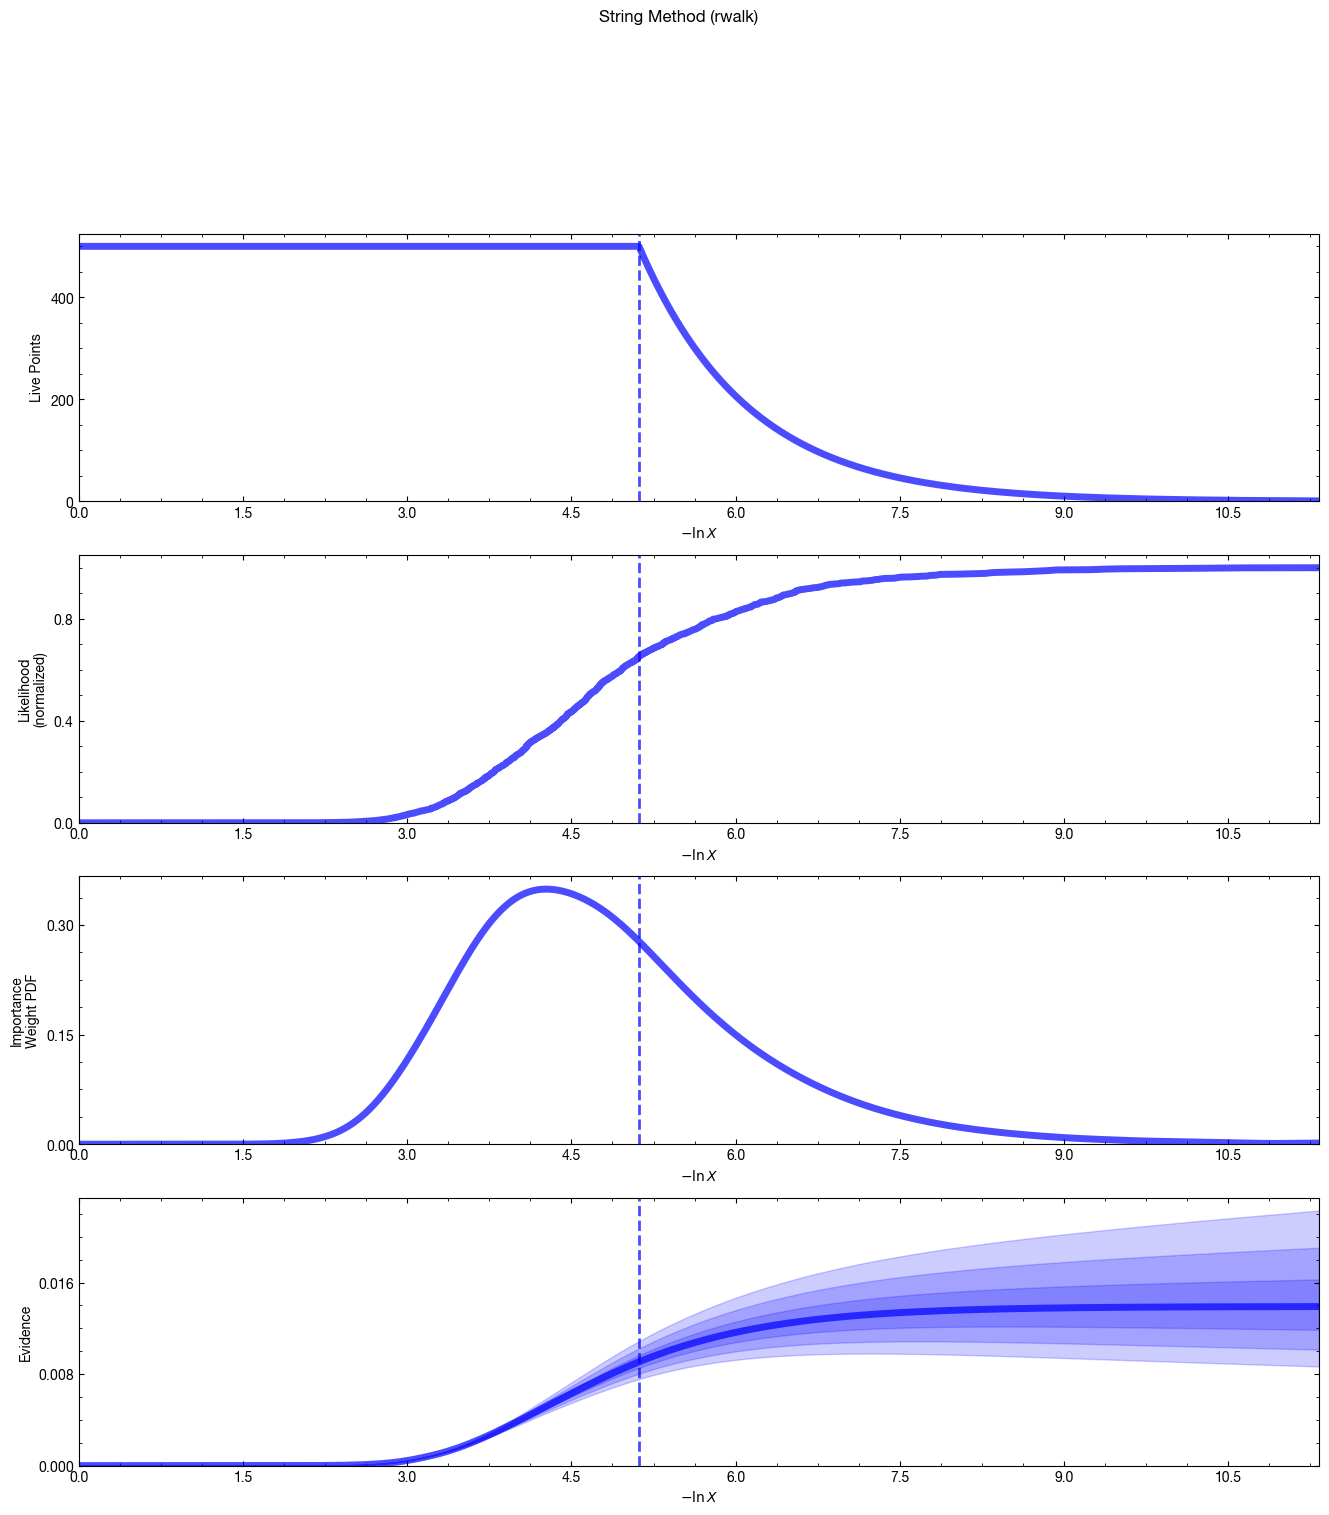

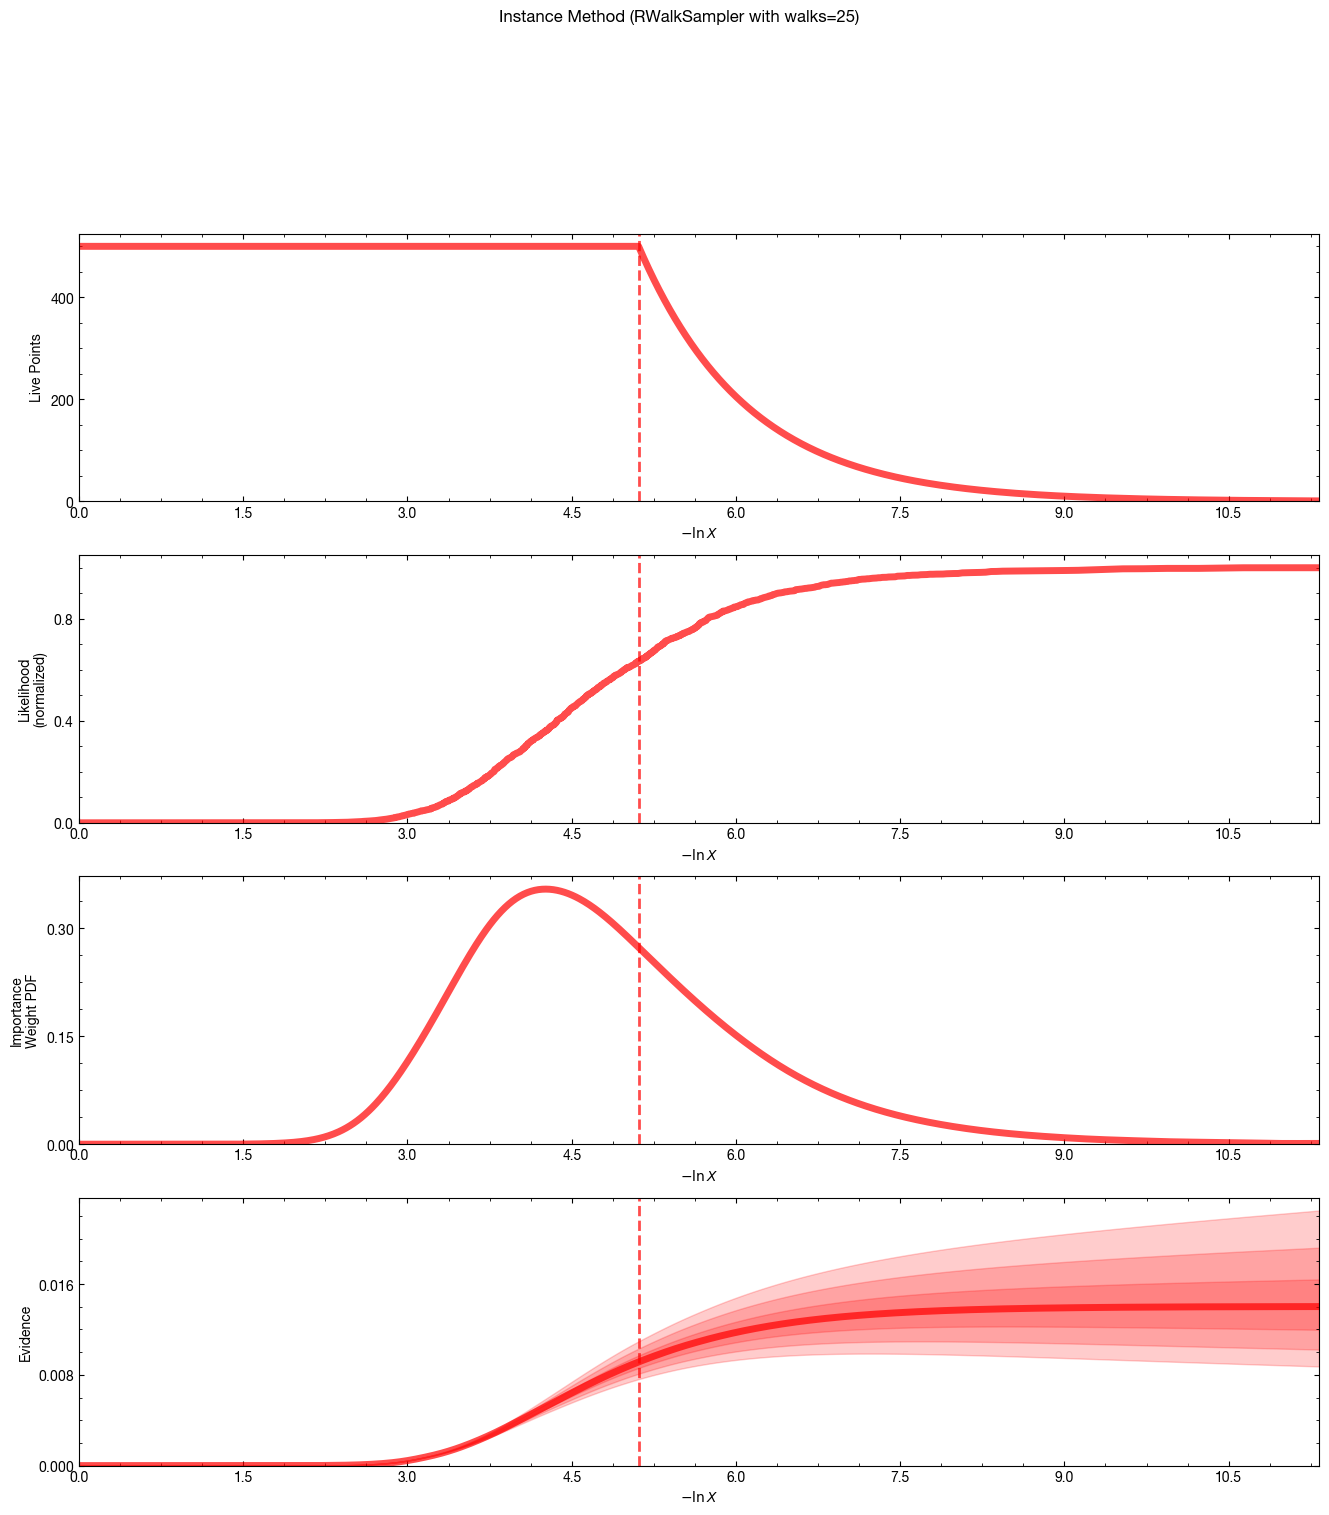

In [9]:
# Compare the two approaches visually
print("Comparing string method vs instance method:")
print(f"String method evidence: {results_str.logz[-1]:.3f} ± {results_str.logzerr[-1]:.3f}")
print(f"Instance method evidence: {results_inst.logz[-1]:.3f} ± {results_inst.logzerr[-1]:.3f}")

# Plot run diagnostics for both
fig_str, axes_str = dyplot.runplot(results_str, color='blue')
fig_str.suptitle('String Method (rwalk)', y=1.02)
plt.show()

fig_inst, axes_inst = dyplot.runplot(results_inst, color='red')
fig_inst.suptitle('Instance Method (RWalkSampler with walks=25)', y=1.02)
plt.show()


## 3b. Custom Bounding and Sampler Interfaces

Similarly to the sampler interface, v3.0 also allows you to provide bounding objects directly, giving you fine-grained control over the bounding distribution.


### Using Bounding Objects Directly


In [10]:
from dynesty.bounding import Ellipsoid

rstate = np.random.default_rng(200)

# Using string (classic approach)
sampler_bound_str = dynesty.NestedSampler(loglike, prior_transform, ndim, 
                                          bound='single', rstate=rstate)
sampler_bound_str.run_nested()
print(f"String bound method: logz = {sampler_bound_str.results.logz[-1]:.3f}")

# Using bounding object directly (new in v3.0)
rstate = np.random.default_rng(200)
custom_bound = Ellipsoid(ndim)  # Create an ellipsoid bounding object
sampler_bound_obj = dynesty.NestedSampler(loglike, prior_transform, ndim,
                                          bound=custom_bound, rstate=rstate)
sampler_bound_obj.run_nested()
print(f"Bounding object method: logz = {sampler_bound_obj.results.logz[-1]:.3f}")


2527it [00:01, 1440.18it/s, +500 | bound: 3 | nc: 1 | ncall: 19713 | eff(%): 15.755 | loglstar:   -inf < -0.001 <    inf | logz: -4.216 +/-  0.081 | dlogz:  0.001 >  0.509]


String bound method: logz = -4.216


2527it [00:01, 1409.89it/s, +500 | bound: 3 | nc: 1 | ncall: 19713 | eff(%): 15.755 | loglstar:   -inf < -0.001 <    inf | logz: -4.216 +/-  0.081 | dlogz:  0.001 >  0.509]

Bounding object method: logz = -4.216


### Creating Custom Samplers

You can also create your own custom samplers by subclassing `InternalSampler` from `dynesty.internal_samplers`. Your custom sampler needs to implement:

- `__init__()`: Initialize sampler parameters
- `prepare_sampler()`: Prepare arguments for sampling
- `sample()`: A static method that performs the actual sampling
- `tune()`: Update sampler parameters based on acceptance statistics
- `citations`: A property returning citation information

Here's a conceptual example structure:

```python
from dynesty.internal_samplers import InternalSampler

class MyCustomSampler(InternalSampler):
    def __init__(self, my_param=10, **kwargs):
        super().__init__(**kwargs)
        self.my_param = my_param
        # Set up sampler-specific kwargs
        self.sampler_kwargs['my_param'] = my_param
    
    def prepare_sampler(self, loglstar, points, axes, seeds, 
                       prior_transform, loglikelihood, nested_sampler):
        # Prepare list of SamplerArgument objects for parallel execution
        # ... implementation ...
        pass
    
    @staticmethod
    def sample(args):
        # Perform the actual sampling (must be static for multiprocessing)
        # Return SamplerReturn object with u, v, logl, ncalls, etc.
        # ... implementation ...
        pass
    
    def tune(self, tuning_info):
        # Adjust sampler parameters (e.g., step size) based on statistics
        # ... implementation ...
        pass
    
    @property
    def citations(self):
        return [("Author (Year)", "doi.org/...")]

# Use your custom sampler
# sampler = dynesty.NestedSampler(loglike, prior_transform, ndim,
#                                 sample=MyCustomSampler(my_param=20))
```

This provides maximum flexibility for implementing novel sampling strategies while maintaining compatibility with dynesty's infrastructure.


## 4. Performance Improvements

The uniform sampler is now dramatically faster when used with parallelization. Let's demonstrate this with a simple example.

In [11]:
import time
from dynesty.pool import Pool

# Define a slower likelihood to better show parallelization benefits
def loglike_slow(x):
    time.sleep(0.001)  # Small delay
    return -0.5 * np.sum(x**2)

# Single-threaded uniform sampling
start = time.time()
sampler_single = dynesty.NestedSampler(loglike_slow, prior_transform, ndim, 
                                       sample='unif', nlive=100, rstate=rstate)
sampler_single.run_nested()
time_single = time.time() - start
print(f"Single-threaded time: {time_single:.2f} seconds")

# Multi-threaded uniform sampling
with Pool(4, loglike_slow, prior_transform) as pool:
    start = time.time()
    sampler_pool = dynesty.NestedSampler(pool.loglike, pool.prior_transform, ndim,
                                         sample='unif', nlive=100, pool=pool,
                                         rstate=rstate)
    sampler_pool.run_nested()
    time_pool = time.time() - start
    print(f"Multi-threaded time (4 cores): {time_pool:.2f} seconds")
    print(f"Speedup: {time_single/time_pool:.2f}x")

657it [00:07, 89.13it/s, +100 | bound: 6 | nc: 1 | ncall: 4239 | eff(%): 18.289 | loglstar:   -inf < -0.001 <    inf | logz: -4.272 +/-  0.179 | dlogz:  0.001 >  0.109]

Single-threaded time: 7.53 seconds



644it [00:04, 133.84it/s, +100 | bound: 5 | nc: 1 | ncall: 4378 | eff(%): 17.391 | loglstar:   -inf < -0.001 <    inf | logz: -4.141 +/-  0.177 | dlogz:  0.001 >  0.109]

Multi-threaded time (4 cores): 4.89 seconds
Speedup: 1.54x


## 5. Removed Features

Several features have been removed in v3.0 to streamline the API:

- **`n_effective` argument** from the static sampler's `run_nested` method
- **`update_func` argument** (replaced by new sampler interface)
- **'user-defined' proposal distribution** (use the new InternalSampler interface instead)
- **`hslice` sampler** (removed due to performance and correctness issues)

If you were using any of these features, please refer to the documentation for migration guidance.

## Summary

dynesty v3.0 brings several important improvements:

1. **Proposal Statistics**: Better insight into sampler performance with `proposal_stats`
2. **Evaluation History**: Save all likelihood evaluations to HDF5 for detailed analysis
3. **Custom Samplers & Bounds**: More flexible configuration via the InternalSampler and Bounding interfaces - you can now pass sampler/bound instances directly (e.g., `sample=RWalkSampler(walks=25)` or `bound=Ellipsoid(ndim)`) or create fully custom samplers by subclassing `InternalSampler`
4. **Performance**: Dramatically faster uniform sampling with parallelization
5. **Cleaner API**: Removal of deprecated features for better maintainability

For a complete list of changes and migration guide, see the [CHANGELOG](https://github.com/joshspeagle/dynesty/blob/master/CHANGELOG.md).
